In [1]:
import pandas as pd
import numpy as np
from processingNBAscore import *
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen
%matplotlib inline
import math
import re
import pymc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_roster_links(season):
    '''season is the year in which the playoffs open'''
    soup=make_soup(url%str(season))
    T=soup.find('div',{'class':'standings_divs table_wrapper'})
    hrefs=T.findAll('a',href=True)[:30]
    links=[];teamName=[]
    for href in hrefs:
        l=url.split('/l')[0]+href.attrs['href']
        links.append(l)
        teamName.append(href.attrs['href'].split('/')[-2].lower())
    return links,teamName
def get_roster(roster_link,side=False,attrN='NAME'):
    soup=make_soup(roster_link)
    table_area = soup.find('table',{'id':'roster'})
    columns=['NAME','Position','H','W','Birth','Exp','country','College']
    tempTable=[[td.findChildren(text=True) for td in tr.findAll("td")] for tr in table_area.find_all('tr')]
    try:
        tempTable=np.array(tempTable[1:])
        tempTable=pd.DataFrame(tempTable,columns=columns)
        Names=np.concatenate(tempTable.NAME.values)
    except:
        tempTable=np.array(tempTable[1:]);size=tempTable.shape;tempTable=tempTable.reshape(size[0],size[1])
        tempTable=pd.DataFrame(tempTable,columns=columns)
        Names=tempTable.NAME.values
    if side:
        attr=tempTable[attrN].values
        return Names,attr
    else:
        return Names
def get_game_links(season):
    soup=make_soup(url%str(season))
    T=soup.find('div',{'class':'standings_divs table_wrapper'})
    hrefs=T.findAll('a',href=True)[:30]
    links=[];teamName=[]
    for href in hrefs:
        l=url.split('/l')[0]+href.attrs['href'].split('.')[0]+'_games.html'
        links.append(l)
        teamName.append(href.attrs['href'].split('/')[-2].lower())
    return links,teamName
def make_team_map(season):
    team_map={}
    soup=make_soup(url%str(season))
    T=soup.find('div',{'class':'standings_divs table_wrapper'})
    hrefs=T.findAll('a',href=True)[:30]
    links=[];teamName=[]
    for href in hrefs:
        teamName=href.contents[0]
        br=href.attrs['href'].split('/')[-2].lower()
        team_map[teamName]=br
    return team_map

def get_game_schedule(link):
    soup=make_soup(link)
    # get the corrently selected team schedule
    Team_for_data_collection=soup.find('div',{'class':'table_outer_container'})
    # get the table of that schedule
    Team_schedule=[[td.findChildren(text=True) for td in tr.findAll("td")] for tr in Team_for_data_collection.find_all('tr')]
    # parse the data to a table
    Team_schedule=np.array(Team_schedule[1:])
    Schedule_table=[]
    for game in Team_schedule:
        if len(game)>0:
            Schedule_table.append(game)
    Schedule_table=np.array(Schedule_table)
    cols=['date','time','empty1','box score','at','opp','w_l','OT','teamscore','oppscore','win','loss','streak','notes']
    df=pd.DataFrame(Schedule_table,columns=cols)
    return df
def get_game_score(df,teamName,team_map):
    team1=teamName
    home=[];away=[];home_score=[];away_score=[]
    for row in df.iterrows():
        team2=team_map[row[1][5][0]];print(team2,end=', ')
        if row[1][4] == []:
            home.append(team1);away.append(team2)
            home_score.append(int(row[1][8][0]));away_score.append(int(row[1][9][0]))
        else:
            home.append(team2);away.append(team1)
            home_score.append(int(row[1][9][0]));away_score.append(int(row[1][8][0]))  
    return home,away,home_score,away_score

def playoffs_teams(season):
    soup=make_soup(url.split('/leagues')[0] + '/playoffs/NBA_%s.html'%season)
    T=soup.find('div',{'id':'all_all_team_stats'})
    C=[[td.findChildren(text=True) for td in tr.findAll("td")] for tr in T.find_all('tr')]
    C=np.array(C[1:-1])
    Name=[i[0][0] for i in C]
    return Name

In [3]:
def get_box_score_links(link):
    soup=make_soup(link)
    links=[]
    T=soup.find_all('a',href=True)
    for href in T:
        if 'Box Score' in href.contents[0]:
            l ='http://www.basketball-reference.com'+href.attrs['href']
            links.append(l)
    return links
def link_to_table(link):
    soup=make_soup(link)
    T = soup.find_all('div',{'class':'table_outer_container'})
    return T
def get_box_score(T):
    table_name=['basic_1','advance_1','basic_2','advance_2']
    col1=['min','FG','FGA','FG %','3PM','3PA','3P %','FTM','FTA','FT %','ORB',
      'DRB',"TRB","AST","STL","BLK","TO",'foul','points']
    col2=["min",'TS %',"effective FG %","3P Attp Rt","FT Rt","ORB Rt","DRB Rt","TRB Rt",
      "AST Rt","STL Rt","BLK Rt","TO Rt","USG","Off Rr","Def Rr"]
    D={}
    for ii,t in enumerate(T):
        C=[[td.findChildren(text=True) for td in tr.findAll("td")] for tr in t.find_all('tr')]
        if ii%2 == 0:
            c=col1
            K_table=pd.DataFrame(np.array(C[-1][:19]).T,columns=c);
        else:
            c=col2
            K_table=pd.DataFrame(np.array(C[-1]).T,columns=c);
        D[table_name[ii]]=K_table
    return D

In [4]:
def get_game_feature(df,teamName,team_map,teamLink,stats='basic_',feature='points'):
    team1=teamName
    home=[];away=[];home_stats=[];away_stats=[]
    box_score_links=get_box_score_links(teamLink)
    for ii,row in enumerate(df.iterrows()):
        team2=team_map[row[1][5][0]];print(team2,end=', ')
        T = link_to_table(box_score_links[ii])
        D = get_box_score(T)
        if row[1][4] == []:
            home.append(team1);away.append(team2)
            home_stats.append(float(D[stats+'1'][feature][0]));away_stats.append(float(D[stats+'2'][feature][0]))
        else:
            home.append(team2);away.append(team1)
            home_stats.append(float(D[stats+'2'][feature][0]));away_stats.append(float(D[stats+'1'][feature][0]))
    return home, away,home_stats,away_stats

In [6]:
season=2015;start_date=str(season-1);end_date=str(season)
links,teamNames = get_roster_links(season)
team_map_for_posterior_plotting=make_team_map(season)

# See if I get the game stats and replicate what I have done

In [ ]:
teamLinks,teamNames=get_game_links(season)

df_temp=[]
for link, teamName in zip(teamLinks,teamNames):
    df_schedule = get_game_schedule(link)
    print('\n\n%s'%teamName,end='::::')
    """
    home,away,home_score,away_score=get_game_score(df_schedule,teamName,team_map_for_posterior_plotting)
    df_temp.append(pd.DataFrame({'home':home,'away':away,'home_score':home_score,'away_score':away_score}))
    """
    ################################################################
    home,away,home_scores,away_scores=get_game_feature(df_schedule,teamName,team_map_for_posterior_plotting,
                                                     link,stats='basic_',feature='points')
    _,_,home_rebs,away_rebs=get_game_feature(df_schedule,teamName,team_map_for_posterior_plotting,
                                                     link,stats='basic_',feature='TRB')
    _,_,home_asts,away_asts=get_game_feature(df_schedule,teamName,team_map_for_posterior_plotting,
                                                     link,stats='basic_',feature='AST')
    _,_,home_offR,away_offR=get_game_feature(df_schedule,teamName,team_map_for_posterior_plotting,
                                                     link,stats='advance_',feature='Off Rr')
    ################################################################
    df_temp.append(pd.DataFrame({'home':home,'away':away,'home_scores':home_scores,
                                 'away_scores':away_scores,'home_rebs':home_rebs,
                                'away_rebs':away_rebs,'home_asts':home_asts,
                                'away_asts':away_asts,'home_off_rate':home_offR,
                                'away_off_rate':away_offR}))
    print('\n # home: %d'%np.unique(home).shape[0])
print('\n\nFinished\n')
df=pd.concat(df_temp)
dict_team = {}
for ii,item in enumerate(pd.unique(df['home'])):
    dict_team[item]=ii

df['i_home'] = df.home.map(dict_team)
df['i_away'] = df.away.map(dict_team)
teams=pd.DataFrame({'team':pd.unique(df.home)})
teams['i']=teams['team'].map(dict_team)

In [ ]:
df.to_csv('NBA%s%s.csv'%(start_date,end_date),
          index=False)

In [7]:
df = pd.read_csv('NBA%s%s.csv'%(start_date,end_date))
dict_team = {}
for ii,item in enumerate(pd.unique(df['home'])):
    dict_team[item]=ii
teams=pd.DataFrame({'team':pd.unique(df.home)})
teams['i']=teams['team'].map(dict_team)

In [8]:
df.head(1)

,away,away_asts,away_rebs,away_scores,home,home_asts,home_rebs,home_scores,i_home,i_away
0,atl,26.0,48.0,109.0,tor,26.0,42.0,102.0,0,5


In [9]:
"""
This next step is unnecessary, but I like to do it anyway - come up with some 
decent starting values for the att and def parameters. The log transformation 
will make sense shortly.
"""
att_score_starting_points = np.log((df.groupby('i_home').home_scores.mean() + df.groupby('i_home').away_scores.mean())/2)
att_reb_starting_points = np.log((df.groupby('i_home').home_rebs.mean() + df.groupby('i_home').away_rebs.mean())/2)
att_ast_starting_points = np.log((df.groupby('i_home').home_asts.mean() + df.groupby('i_home').away_asts.mean())/2)
att_off_starting_points = np.log((df.groupby('i_home').home_off_rate.mean() + df.groupby('i_home').away_off_rate.mean())/2)

def_score_starting_points =-np.log((df.groupby('i_away').away_scores.mean()+df.groupby('i_away').home_scores.mean())/2)# the higher the better
def_reb_starting_points =-np.log((df.groupby('i_away').away_rebs.mean()+df.groupby('i_away').home_rebs.mean())/2)
def_ast_starting_points =-np.log((df.groupby('i_away').away_asts.mean()+df.groupby('i_away').home_asts.mean())/2)
def_off_starting_points =-np.log((df.groupby('i_away').away_off_rate.mean()+df.groupby('i_away').home_off_rate.mean())/2)

AttributeError: 'DataFrameGroupBy' object has no attribute 'home_off_rate'

NameError: name 'def_score_starting_points' is not defined

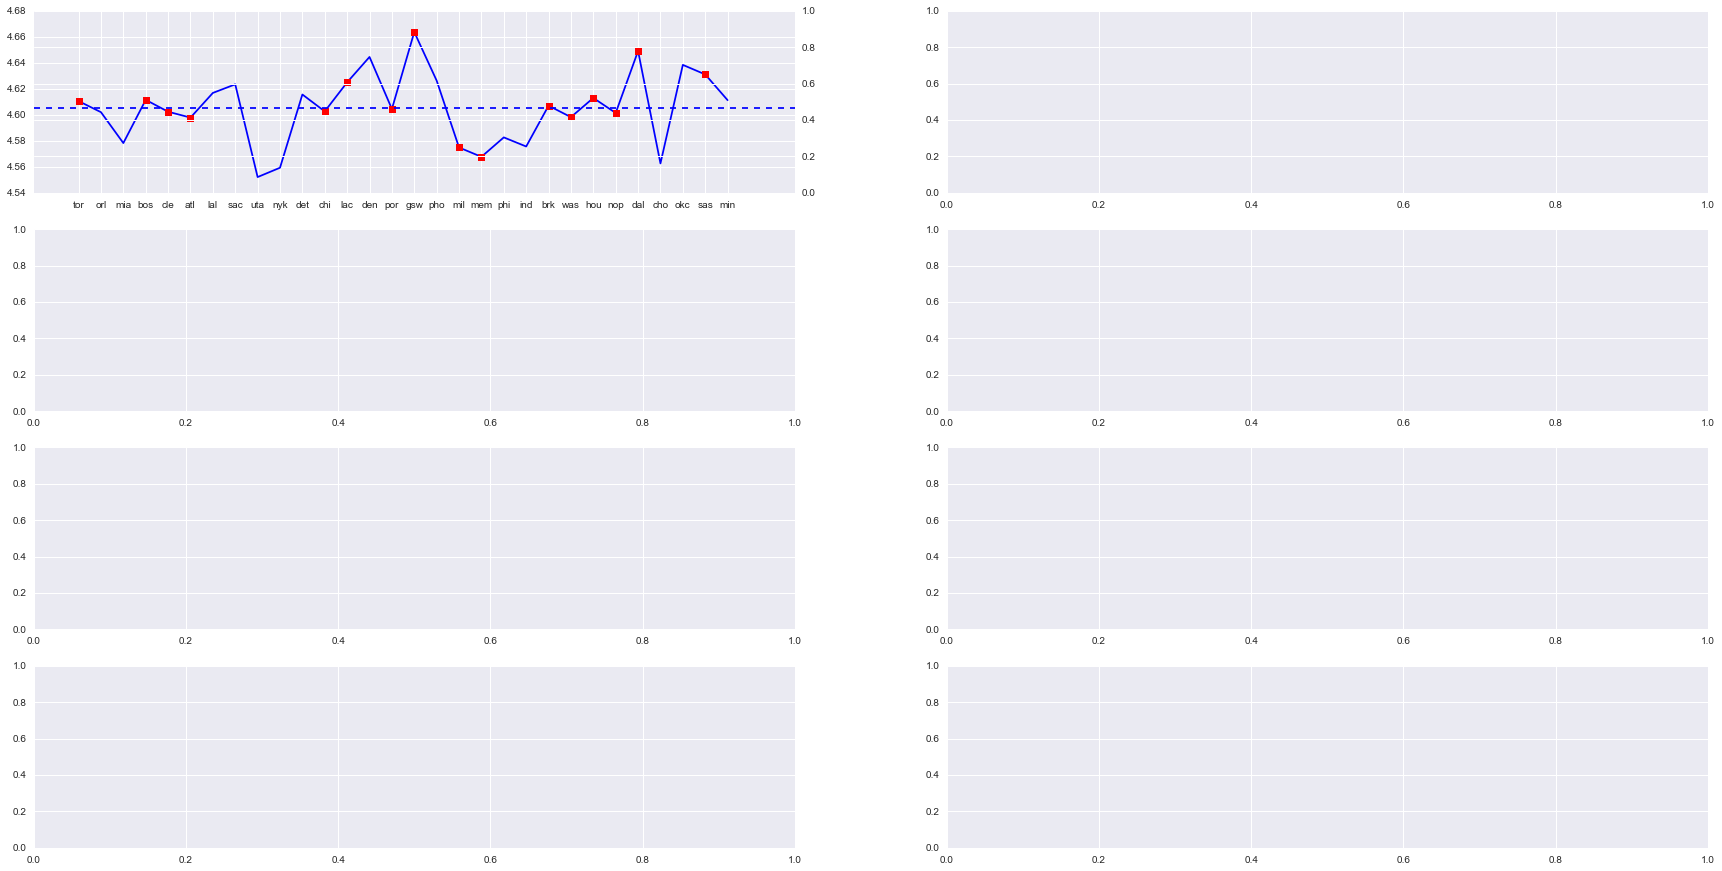

In [10]:
fig, ax = plt.subplots(figsize=(30,15),
                        nrows=4, ncols=2)

Name=playoffs_teams(season)
playoffIdx=[dict_team[b] for b in [team_map_for_posterior_plotting[k] for k in Name]]
ii=(0,0)
ln=ax[ii].plot(np.arange(30),att_score_starting_points.values,color='blue',label='offense')
lnp=ax[ii].plot(np.arange(30)[playoffIdx],att_score_starting_points.values[playoffIdx],'rs',label='playoffs teams')
ax[ii].axhline(att_score_starting_points.values.mean(),color='blue',label='mean points made',linestyle='--')
_=ax[ii].set(xticks=np.arange(30),xticklabels=teams['team'],xlim=[-2,32])
ax1=ax[ii].twinx()
ln1=ax1.plot(np.arange(30),def_score_starting_points.values,color='red',label='defense')
ax1.plot(np.arange(30)[playoffIdx],def_score_starting_points.values[playoffIdx],'bs')
ax1.axhline(def_score_starting_points.values.mean(),color='red',label='mean points allowed',linestyle='--')
_=ax1.set(title='season %s - %s points' % (start_date[:4],end_date[:4]))
lns=ln + ln1 + lnp
labs = [l.get_label() for l in lns]
ax[ii].legend(lns,labs,loc='best')
ii=(0,1)
ax[ii].plot(np.arange(30),att_score_starting_points.values+def_score_starting_points.values)
ax[ii].plot(np.arange(30)[playoffIdx],(att_score_starting_points.values+def_score_starting_points.values)[playoffIdx],'rs',
           label='playoffs teams')
ax[ii].axhline(0,color='r',linestyle='--')
ax[ii].set(xlabel='teams',ylabel='difference',title='difference between offense and defense',xticks=np.arange(30),
          xticklabels=teams['team'])
ax[ii].legend(loc='best')
ii=(1,0)
ln=ax[ii].plot(np.arange(30),att_reb_starting_points.values,color='blue',label='reb get')
lnp=ax[ii].plot(np.arange(30)[playoffIdx],att_reb_starting_points.values[playoffIdx],'rs',label='playoffs teams')
ax[ii].axhline(att_reb_starting_points.values.mean(),color='blue',label='mean offense',linestyle='--')
_=ax[ii].set(xticks=np.arange(30),xticklabels=teams['team'],xlim=[-2,32])
ax1=ax[ii].twinx()
ln1=ax1.plot(np.arange(30),def_reb_starting_points.values,color='red',label='reb allowed')
ax1.plot(np.arange(30)[playoffIdx],def_reb_starting_points.values[playoffIdx],'bs')
ax1.axhline(def_reb_starting_points.values.mean(),color='red',label='mean defense',linestyle='--')
_=ax1.set(title='season %s - %s rebound' % (start_date[:4],end_date[:4]))
lns=ln + ln1 + lnp
labs = [l.get_label() for l in lns]
ii=(1,1)
ax[ii].legend(lns,labs,loc='best')
ax[ii].plot(np.arange(30),att_reb_starting_points.values+def_reb_starting_points.values)
ax[ii].plot(np.arange(30)[playoffIdx],(att_reb_starting_points.values+def_reb_starting_points.values)[playoffIdx],'rs',
           label='playoffs teams')
ax[ii].axhline(0,color='r',linestyle='--')
ax[ii].set(xlabel='teams',ylabel='difference',title='difference between reb got and reb allowed',xticks=np.arange(30),
          xticklabels=teams['team'])
ax[ii].legend(loc='best')
ii=(2,0)
ln=ax[ii].plot(np.arange(30),att_ast_starting_points.values,color='blue',label='ast made')
lnp=ax[ii].plot(np.arange(30)[playoffIdx],att_ast_starting_points.values[playoffIdx],'rs',label='playoffs teams')
ax[ii].axhline(att_ast_starting_points.values.mean(),color='blue',label='mean offense',linestyle='--')
_=ax[ii].set(xticks=np.arange(30),xticklabels=teams['team'],xlim=[-2,32])
ax1=ax[ii].twinx()
ln1=ax1.plot(np.arange(30),def_ast_starting_points.values,color='red',label='ast allowed')
ax1.plot(np.arange(30)[playoffIdx],def_ast_starting_points.values[playoffIdx],'bs')
ax1.axhline(def_ast_starting_points.values.mean(),color='red',label='mean defense',linestyle='--')
_=ax1.set(title='season %s - %s assist' % (start_date[:4],end_date[:4]))
lns=ln + ln1 + lnp
labs = [l.get_label() for l in lns]
ax[ii].legend(lns,labs,loc='best')
ii=(2,1)
ax[ii].legend(lns,labs,loc='best')
ax[ii].plot(np.arange(30),att_ast_starting_points.values+def_ast_starting_points.values)
ax[ii].plot(np.arange(30)[playoffIdx],(att_ast_starting_points.values+def_ast_starting_points.values)[playoffIdx],'rs',
           label='playoffs teams')
ax[ii].axhline(0,color='r',linestyle='--')
ax[ii].set(xlabel='teams',ylabel='difference',title='difference between ast made and ast allowed',xticks=np.arange(30),
          xticklabels=teams['team'])
ax[ii].legend(loc='best')
ii=(3,0)
ln=ax[ii].plot(np.arange(30),att_off_starting_points.values,color='blue',label='offense rate')
lnp=ax[ii].plot(np.arange(30)[playoffIdx],att_off_starting_points.values[playoffIdx],'rs',label='playoffs teams')
ax[ii].axhline(att_off_starting_points.values.mean(),color='blue',label='mean offense rate',linestyle='--')
_=ax[ii].set(xticks=np.arange(30),xticklabels=teams['team'],xlim=[-2,32])
ax1=ax[ii].twinx()
ln1=ax1.plot(np.arange(30),def_off_starting_points.values,color='red',label='opponant offense rate')
ax1.plot(np.arange(30)[playoffIdx],def_off_starting_points.values[playoffIdx],'bs')
ax1.axhline(def_off_starting_points.values.mean(),color='red',label='mean defense rate',linestyle='--')
_=ax1.set(title='season %s - %s assist' % (start_date[:4],end_date[:4]))
lns=ln + ln1 + lnp
labs = [l.get_label() for l in lns]
ax[ii].legend(lns,labs,loc='best')
ii=(3,1)
ax[ii].legend(lns,labs,loc='best')
ax[ii].plot(np.arange(30),att_off_starting_points.values+def_off_starting_points.values)
ax[ii].plot(np.arange(30)[playoffIdx],(att_off_starting_points.values+def_off_starting_points.values)[playoffIdx],'rs',
           label='playoffs teams')
ax[ii].axhline(0,color='r',linestyle='--')
ax[ii].set(xlabel='teams',ylabel='difference',title='difference between offense rate and defense rate',xticks=np.arange(30),
          xticklabels=teams['team'])
ax[ii].legend(loc='best')
fig.tight_layout()
#fig.savefig('save something.png',dpi=100)

The model is from Deneil's blog:

$$ y_{gj} | \theta_{gj} = \text{Poisson}(\theta_{gj})$$

where the $\theta = (\theta_{g \text{ home}},\theta_{g \text{ away}})$ represent the scoring intensity in the g-th game for team playing at home and away. They use a log-linear model for the thetas:
$$ log\theta_{g \text{ home}} = home + home_{score}{h(g)} + away_{score}{a(g)} + home_{reb}{h(g)} + away_{reb}{a(g)} + home_{ast}{h(g)} + away_{ast}{a(g)}$$
$$ log\theta_{g \text{ away}} = home_{score}{a(g)} + away_{score}{h(g)} + home_{reb}{a(g)} + away_{reb}{h(g)} + home_{ast}{a(g)} + away_{ast}{h(g)}$$
Note that they're breaking out team strength into offense and awayense strength. A negative awayense parameter will sap the mojo from the opposing team's offense parameter.

*home* represents home-court advantage, and in this model is assumed to be constant across teams. (In real world, we know there is home court advantage). The prior on the home and intercept parameters is flat:
$$ home \sim Normal(0,.0001) $$
$$ intercept \sim Normal(0,.0001)$$
The team-specific effect are modeled as exchangeable:
$$ home_t \sim Normal(\mu_{home}, \tau_{home})$$
$$ away_t \sim Normal(\mu_{away},\tau_{away})$$
To ensure identifiability, they impose a sum-to-zero constraint on the offense and awayense parameters. They also tried a corner constraint (pinning one team's parameter to 0,0), but found that interpretation is easier in the sum-to-zero case because it's not relateive to the 0,0 team.
$$ \sum^T_{t=1} home_t = 0$$
$$ \sum^T_{t=1} away_t = 0$$
The hyper priors on the offense and awayense parameters are also flat

# [Daneil's](http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/) Tweaks

It didn't make sense to have a $\mu_{home}$ when we're enforcing the sum-to-zero constraint by subtracting the mean anyway.
$$ home_t \sim Normal(0,\tau_{home})$$
$$ away_t \sim Normal(0,\tau_{away})$$
Also because of the sum-to-zero constraint, it seemed to need an intercept term in the log-linear model, capturing the average scores per game by the away team:
1. parameters for each stats
$$log\theta_{g \text{ home}} = intercept + home + home_{stats}{h(g)} + away_{stats}{a(g)}$$
$$log\theta_{g \text{ away}} = intercept + home_{stats}{a(g)} + away_{stats}{h(g)}$$
2. parameters for overall statistics - here I will use offense rating computed by the website
$$ log\theta_{g \text{ home}} = intercept + home + home_{score}{h(g)} + away_{score}{a(g)} + home_{reb}{h(g)} + away_{reb}{a(g)} + home_{ast}{h(g)} + away_{ast}{a(g)}$$
$$ log\theta_{g \text{ away}} = intercept + home_{score}{a(g)} + away_{score}{h(g)} + home_{reb}{a(g)} + away_{reb}{h(g)} + home_{ast}{a(g)} + away_{ast}{h(g)}$$

In [ ]:
###################     prepare for the model ################################
observed_home_scores = df.home_scores.values
observed_away_scores = df.away_scores.values
observed_home_rebs   = df.home_rebs.values
observed_away_rebs   = df.away_rebs.values
observed_home_asts   = df.home_asts.values
observed_away_asts   = df.away_asts.values
observed_home_offs   = df.home_off_rate.values
observed_away_offs   = df.away_off_rate.values

home_team = df.i_home.values;home_team=home_team.astype(np.int8)
away_team = df.i_away.values;away_team=away_team.astype(np.int8)
num_teams = len(teams['team'])
num_games = len(home_team)
##################    Model    ##############################################
#hyperpriors
home = pymc.Normal('home', 0, .0001, value=0.5)

tau_att_score = pymc.Gamma('tau_att_score', .1, .1, value=10)
tau_def_score = pymc.Gamma('tau_def_score', .1, .1, value=10)
tau_att_reb   = pymc.Gamma('tau_att_reb',.1,.1,value=10)
tau_def_reb   = pymc.Gamma('tau_def_reb',.1,.1,value=10)
tau_att_ast   = pymc.Gamma('tau_att_ast',.1,.1,value=10)
tau_def_ast   = pymc.Gamma('tau_def_ast',.1,.1,value=10)
tau_att_off   = pymc.Gamma('tau_att_off',.1,.1,value=10)
tau_def_off   = pymc.Gamma('tau_def_off',.1,.1,value=10)

intercept_score = pymc.Normal('intercept_score', 0, .0001, value=0)
intercept_reb   = pymc.Normal('intercept_reb', 0, .0001, value=0)
intercept_ast   = pymc.Normal('intercept_ast', 0, .0001, value=0)
intercept_off   = pymc.Normal('intercept_off', 0, .0001, value=0)
#intercept_def_score = pymc.Normal('intercept_def_score', 0, .0001, value=0)
#intercept_def_reb   = pymc.Normal('intercept_def_reb', 0, .0001, value=0)
#intercept_def_ast   = pymc.Normal('intercept_def_ast', 0, .0001, value=0)
#intercept_def_off   = pymc.Normal('intercept_def_off', 0, .0001, value=0)
beta_att = pymc.Normal('beta_att',0,0.01,size=4)
beta_def = pymc.Normal('beta_def',0,0.01,size=4)

In [ ]:
#team-specific parameters
atts_score_star = pymc.Normal("atts_score_star", 
                        mu=0, 
                        tau=tau_att_score, 
                        size=num_teams, 
                        value=att_score_starting_points.values)
defs_score_star = pymc.Normal("defs_score_star", 
                        mu=0, 
                        tau=tau_def_score, 
                        size=num_teams, 
                        value=def_score_starting_points.values)
atts_reb_star = pymc.Normal("atts_reb_star", 
                        mu=0, 
                        tau=tau_att_reb, 
                        size=num_teams, 
                        value=att_reb_starting_points.values)
defs_reb_star = pymc.Normal("defs_reb_star", 
                        mu=0, 
                        tau=tau_def_reb, 
                        size=num_teams, 
                        value=def_reb_starting_points.values) 
atts_ast_star = pymc.Normal("atts_ast_star", 
                        mu=0, 
                        tau=tau_att_ast, 
                        size=num_teams, 
                        value=att_ast_starting_points.values)
defs_ast_star = pymc.Normal("defs_ast_star", 
                        mu=0, 
                        tau=tau_def_ast, 
                        size=num_teams, 
                        value=def_ast_starting_points.values) 
atts_off_star = pymc.Normal('atts_off_star',
                           mu=0,
                           tau=tau_att_off,
                           size=num_teams,
                           value=att_off_starting_points.values)
defs_off_star = pymc.Normal('defs_off_star',
                           mu=0,
                           tau=tau_def_off,
                           size=num_teams,
                           value=def_off_starting_points.values)

In [ ]:
# trick to code the sum to zero contraint
@pymc.deterministic
def atts_score(atts_star=atts_score_star):
    atts = atts_star.copy()
    atts =( atts - np.mean(atts_star))
    return atts

@pymc.deterministic
def defs_score(defs_star=defs_score_star):
    defs = defs_star.copy()
    defs = (defs - np.mean(defs_star))
    return defs

@pymc.deterministic
def atts_reb(atts_star=atts_reb_star):
    atts = atts_star.copy()
    atts =( atts - np.mean(atts_star))
    return atts

@pymc.deterministic
def defs_reb(defs_star=defs_reb_star):
    defs = defs_star.copy()
    defs = (defs - np.mean(defs_star))
    return defs

@pymc.deterministic
def atts_ast(atts_star=atts_ast_star):
    atts = atts_star.copy()
    atts =( atts - np.mean(atts_star))
    return atts

@pymc.deterministic
def defs_ast(defs_star=defs_ast_star):
    defs = defs_star.copy()
    defs = (defs - np.mean(defs_star))
    return defs

@pymc.deterministic
def atts_off(atts_star=atts_off_star):
    atts = atts_star.copy()
    atts = (atts - np.mean(atts_star))
    return atts

@pymc.deterministic
def defs_off(defs_star=defs_off_star):
    defs = defs_star.copy()
    defs = (defs - np.mean(defs_star))
    return defs

In [ ]:
@pymc.deterministic
def home_theta_score(home_team=home_team, # index of home team
                   away_team=away_team, # index of away team
                   home=home, # prior home advantage
                   atts=atts_score, # mean center offense
                   defs=defs_score, # mean center defense
                   atts_reb=atts_reb,
                   defs_reb=defs_reb,
                   atts_ast=atts_ast,
                   defs_ast=defs_ast,
                   intercept=intercept_score):
    return np.exp(intercept + home + 
                  atts[home_team] + 
                  defs[away_team] + 
                  atts_reb[home_team] +
                  defs_reb[away_team] +
                  atts_ast[home_team] +
                  defs_ast[away_team])
  
@pymc.deterministic
def away_theta_score(home_team=home_team, 
                   away_team=away_team, 
                   home=home, 
                   atts=atts_score, 
                   defs=defs_score, 
                   atts_reb=atts_reb,
                   defs_reb=defs_reb,
                   atts_ast=atts_ast,
                   defs_ast=defs_ast,
                   intercept=intercept_score): 
    return np.exp(intercept + 
                  atts[away_team] + 
                  defs[home_team] +
                  atts_reb[away_team] +
                  defs_reb[home_team] +
                  atts_ast[away_team] +
                  defs_ast[home_team]) 

@pymc.deterministic
def home_theta_reb(home_team=home_team, # index of home team
                   away_team=away_team, # index of away team
                   home=home, # prior home advantage
                   atts=atts_reb, # mean center offense
                   defs=defs_reb, # mean center defense
                   atts_score=atts_score,
                   defs_score=defs_score,
                   intercept=intercept_reb): 
    return np.exp(intercept + home + 
                  atts[home_team] + 
                  defs[away_team] +
                  atts_score[home_team] +
                  defs_score[away_team])
  
@pymc.deterministic
def away_theta_reb(home_team=home_team, 
                   away_team=away_team, 
                   home=home, 
                   atts=atts_reb, 
                   defs=defs_reb,
                   atts_score=atts_score,
                   defs_score=defs_score,
                   intercept=intercept_reb): 
    return np.exp(intercept + 
                  atts[away_team] + 
                  defs[home_team] +
                  atts[away_team] +
                  defs[home_team])   

@pymc.deterministic
def home_theta_ast(home_team=home_team, # index of home team
                   away_team=away_team, # index of away team
                   home=home, # prior home advantage
                   atts=atts_ast, # mean center offense
                   defs=defs_ast, # mean center defense
                   atts_score=atts_score,
                   defs_score=defs_score,
                   intercept=intercept_ast): 
    return np.exp(intercept + home + 
                  atts[home_team] + 
                  defs[away_team] +
                  atts_score[home_team] +
                  defs_score[away_team])
  
@pymc.deterministic
def away_theta_ast(home_team=home_team, 
                   away_team=away_team, 
                   home=home, 
                   atts=atts_ast, 
                   defs=defs_ast,
                   atts_score=atts_score,
                   defs_score=defs_score,
                   intercept=intercept_ast): 
    return np.exp(intercept + 
                  atts[away_team] + 
                  defs[home_team] +
                  atts_score[away_team] +
                  defs_score[home_team])



In [ ]:
@pymc.deterministic
def home_theta_off(home_team=home_team,
                   away_team=away_team,
                  home=home,
                  atts=atts_off,
                  defs=defs_off,
                  atts_score=atts_score,
                  defs_score=defs_score,
                  intercept=intercept_off):
    return np.exp(intercept + home + atts[home_team]+defs[away_team]+atts_score[home_team]+defs_score[away_team])

@pymc.deterministic
def away_theta_off(home_team=home_team,
                   away_team=away_team,
                  atts=atts_off,
                  defs=defs_off,
                  atts_score=atts_score,
                  defs_score=defs_score,
                  intercept=intercept_off):
    return np.exp(intercept + atts[away_team]+defs[home_team]+atts_score[away_team]+defs_score[home_team])

In [ ]:
home_scores = pymc.Poisson('home_scores', 
                          mu=home_theta_score, 
                          value=observed_home_scores, 
                          observed=True)
away_scores = pymc.Poisson('away_scores', 
                          mu=away_theta_score, 
                          value=observed_away_scores, 
                          observed=True)
home_reb = pymc.Poisson('home_reb', 
                          mu=home_theta_reb, 
                          value=observed_home_rebs, 
                          observed=True)
away_reb = pymc.Poisson('away_reb', 
                          mu=away_theta_reb, 
                          value=observed_away_rebs, 
                          observed=True)
home_ast = pymc.Poisson('home_ast', 
                          mu=home_theta_ast, 
                          value=observed_home_asts, 
                          observed=True)
away_ast = pymc.Poisson('away_ast', 
                          mu=away_theta_ast, 
                          value=observed_away_asts, 
                          observed=True)
home_off = pymc.Poisson('home_off',
                       mu=home_theta_off,
                       value=observed_home_offs,
                       observed=True)
away_off = pymc.Poisson('away_off',
                       mu=away_theta_off,
                       value=observed_away_offs,
                       observed=True)

In [ ]:
mcmc = pymc.MCMC([home, 
                  intercept_score,
                  intercept_reb,
                  intercept_ast,
                  intercept_off,
                  tau_att_score, tau_def_score,
                  tau_att_reb, tau_def_reb,
                  tau_att_ast, tau_def_reb,
                  tau_att_off,tau_def_off,
                  home_theta_score, away_theta_score,
                  home_theta_reb, away_theta_reb,
                  home_theta_ast,away_theta_ast,
                  home_theta_off, away_theta_off,
                  atts_score_star, defs_score_star, 
                  atts_reb_star, defs_reb_star,
                  atts_ast_star,defs_ast_star,
                  atts_off_star,defs_off_star,
                  atts_score, defs_score,
                  atts_reb, defs_reb,
                  atts_ast,defs_ast,
                  atts_off,defs_off,
                  home_scores, away_scores,
                  home_reb,away_reb,
                  home_ast,away_ast,
                  home_off,away_off])
map_ = pymc.MAP( mcmc )
map_.fit()
mcmc.sample(200000, 40000, 20)

In [ ]:
pymc.Matplot.plot(home)

pymc.Matplot.plot(intercept_score)
pymc.Matplot.plot(intercept_reb)
pymc.Matplot.plot(intercept_ast)

In [ ]:
df_hpd = pd.DataFrame(atts_score.stats()['95% HPD interval'].T, 
                      columns=['hpd_low', 'hpd_high'], 
                      index=teams.team.values)
df_median = pd.DataFrame(atts_score.stats()['quantiles'][50], 
                         columns=['hpd_median'], 
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_index(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(20,9))
axs.errorbar(df_hpd.x, df_hpd.hpd_median, yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o',label='points made')
axs.axhline(0,color='r')
_=axs.set(xlabel='ranked by points made and allowed',ylabel='Posterior scores',xticks=(df_hpd.index + .5))
_=axs.annotate('HPD of points made, by Team season %s-%s'%(start_date,end_date),xy=(11,0.05))
_=axs.set_xticklabels(df_hpd['index'].values,rotation=45)
handles, labels1 = axs.get_legend_handles_labels()
handles1 = [h[0] for h in handles]
df_hpd = pd.DataFrame(defs_score.stats()['95% HPD interval'].T, 
                      columns=['hpd_low', 'hpd_high'], 
                      index=teams.team.values)
df_median = pd.DataFrame(defs_score.stats()['quantiles'][50], 
                         columns=['hpd_median'], 
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_index(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5

ax=axs.twiny()
ax.errorbar(df_hpd.x, df_hpd.hpd_median, yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
            fmt='o',color='r',label='points allowed')
_=ax.set(xticks=(df_hpd.index + .5),xlabel='ranked by points allowed');_=ax.set_xticklabels(df_hpd['index'].values,rotation=45)
handles, labels2 = ax.get_legend_handles_labels()
handles2 = [h[0] for h in handles]
h = handles1 + handles2
labs = ['points made', 'points allowed']
plt.legend(h,labs,loc='upper left')

In [ ]:
df_hpd = pd.DataFrame(atts_reb.stats()['95% HPD interval'].T, 
                      columns=['hpd_low', 'hpd_high'], 
                      index=teams.team.values)
df_median = pd.DataFrame(atts_reb.stats()['quantiles'][50], 
                         columns=['hpd_median'], 
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_index(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(20,9))
axs.errorbar(df_hpd.x, df_hpd.hpd_median, 
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
handles, labels2 = axs.get_legend_handles_labels()
handles1 = [h[0] for h in handles]
axs.axhline(0,color='r')
axs.annotate('HPD of rebound made and allowed, by Team season %s-%s'%(start_date,end_date),xy=(11,0.05))
_=axs.set(xlabel='ranked by reb caught',ylabel='Posterior reb allowed',xticks=(df_hpd.index + .5))
_=axs.set_xticklabels(df_hpd['index'].values,rotation=45)

df_hpd = pd.DataFrame(defs_reb.stats()['95% HPD interval'].T, 
                      columns=['hpd_low', 'hpd_high'], 
                      index=teams.team.values)
df_median = pd.DataFrame(defs_reb.stats()['quantiles'][50], 
                         columns=['hpd_median'], 
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_index(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5
ax=axs.twiny()
ax.errorbar(df_hpd.x, df_hpd.hpd_median, yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
            fmt='o',color='r',label='reb allowed')
_=ax.set(xticks=(df_hpd.index + .5),xlabel='ranked by reb allowed');_=ax.set_xticklabels(df_hpd['index'].values,rotation=45)
handles, labels2 = ax.get_legend_handles_labels()
handles2 = [h[0] for h in handles]
h = handles1 + handles2
labs = ['reb caught', 'reb allowed']
plt.legend(h,labs,loc='best')

In [ ]:
df_hpd = pd.DataFrame(atts_ast.stats()['95% HPD interval'].T, 
                      columns=['hpd_low', 'hpd_high'], 
                      index=teams.team.values)
df_median = pd.DataFrame(atts_ast.stats()['quantiles'][50], 
                         columns=['hpd_median'], 
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_index(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(20,9))
axs.errorbar(df_hpd.x, df_hpd.hpd_median, 
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
axs.axhline(0,color='r')
axs.annotate('HPD of total asts and allowed, by Team season %s-%s'%(start_date,end_date),xy=(11,.05))
_=axs.set(xlabel='ranked by ast made',ylabel='Posterior asts',xticks=(df_hpd.index + .5))
_=axs.set_xticklabels(df_hpd['index'].values,rotation=45)
handles, labels2 = axs.get_legend_handles_labels()
handles1 = [h[0] for h in handles]
df_hpd = pd.DataFrame(defs_ast.stats()['95% HPD interval'].T, 
                      columns=['hpd_low', 'hpd_high'], 
                      index=teams.team.values)
df_median = pd.DataFrame(defs_ast.stats()['quantiles'][50], 
                         columns=['hpd_median'], 
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_index(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5

ax=axs.twiny()
ax.errorbar(df_hpd.x, df_hpd.hpd_median, yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
            fmt='o',color='r',label='reb allowed')
_=ax.set(xticks=(df_hpd.index + .5),xlabel='ranked by ast allowed');_=ax.set_xticklabels(df_hpd['index'].values,rotation=45)
handles, labels2 = ax.get_legend_handles_labels()
handles2 = [h[0] for h in handles]
h = handles1 + handles2
labs = ['ast made', 'ast allowed']
plt.legend(h,labs,loc='best')


In [ ]:
def simulate_season():
    """
    Simulate a season once, using one random draw from the mcmc chain. 
    """
    num_samples = atts_reb.trace().shape[0]
    draw = np.random.randint(0, num_samples)
    atts_draw = pd.DataFrame({'att_score': atts_score.trace()[draw, :],'att_reb':atts_reb.trace()[draw,:],
                              'att_ast':atts_ast.trace()[draw,:],'att_off':atts_off.trace()[draw,:]})
    defs_draw = pd.DataFrame({'def_score': defs_score.trace()[draw, :],'def_reb':defs_reb.trace()[draw,:],
                              'def_ast':defs_ast.trace()[draw,:],'def_off':defs_off.trace()[draw,:]})
    home_draw = home.trace()[draw]
    intercept_draw = pd.DataFrame({'intercept_score':np.random.choice(intercept_score.trace(),size=len(df)),
                                       'intercept_reb'  :np.random.choice(intercept_reb.trace(),size=len(df)),
                                       'intercept_ast'  :np.random.choice(intercept_ast.trace(),size=len(df)),
                                  'intercept_off':np.random.choice(intercept_off.trace(),size=len(df))})
    season = df.copy()
    season = pd.merge(season, atts_draw, left_on='i_home', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_home', right_index=True)
    #season = season.rename(columns = {'att': 'att_home', 'def': 'def_home'})
    season = pd.merge(season, atts_draw, left_on='i_away', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_away', right_index=True)
    season['home_'] = home_draw
    season['intercept_score'] = intercept_draw['intercept_score']
    season['intercept_reb']   = intercept_draw['intercept_reb']
    season['intercept_ast']   = intercept_draw['intercept_ast']
    season['intercept_off']   = intercept_draw['intercept_off']
    # points
    season['home_theta_score'] = season.apply(lambda x: math.exp(x['intercept_score'] + 
                                                               x['home_'] + 
                                                               x['att_score_x'] + 
                                                               x['def_score_y'] +
                                                                x['att_reb_x'] +
                                                                x['def_reb_y'] +
                                                                x['att_ast_x'] +
                                                                x['def_ast_y']), axis=1)
    season['away_theta_score'] = season.apply(lambda x: math.exp(x['intercept_score'] + 
                                                               x['att_score_y'] + 
                                                               x['def_score_x'] +
                                                                x['att_reb_y'] +
                                                                x['def_reb_x'] +
                                                                x['att_ast_y'] +
                                                                x['def_ast_x']), axis=1)
    season['sim_home_score'] = season.apply(lambda x: np.random.poisson(x['home_theta_score']), axis=1)
    season['sim_away_score'] = season.apply(lambda x: np.random.poisson(x['away_theta_score']), axis=1)
    season['home_outcome'] = season.apply(lambda x: 'win' if x['sim_home_score'] > x['sim_away_score'] else 
                                                        'loss' if x['sim_home_score'] < x['sim_away_score'] else 'draw', axis=1)
    season['away_outcome'] = season.apply(lambda x: 'win' if x['sim_home_score'] < x['sim_away_score'] else 
                                                        'loss' if x['sim_home_score'] > x['sim_away_score'] else 'draw', axis=1)

    # assists
    season['home_theta_ast'] = season.apply(lambda x: math.exp(x['intercept_ast'] + 
                                                               x['home_'] + 
                                                               x['att_score_x'] + 
                                                               x['def_score_y'] +
                                                                x['att_ast_x'] +
                                                                x['def_ast_y']), axis=1)
    season['away_theta_ast'] = season.apply(lambda x: math.exp(x['intercept_ast'] + 
                                                               x['att_score_y'] + 
                                                               x['def_score_x'] +
                                                                x['att_ast_y'] +
                                                                x['def_ast_x']), axis=1)
    season['sim_home_ast'] = season.apply(lambda x: np.random.poisson(x['home_theta_ast']), axis=1)
    season['sim_away_ast'] = season.apply(lambda x: np.random.poisson(x['away_theta_ast']), axis=1)

    # rebounds
    season['home_theta_reb'] = season.apply(lambda x: math.exp(x['intercept_reb'] + 
                                                               x['home_'] + 
                                                               x['att_score_x'] + 
                                                               x['def_score_y'] +
                                                                x['att_reb_x'] +
                                                                x['def_reb_y']), axis=1)
    season['away_theta_reb'] = season.apply(lambda x: math.exp(x['intercept_reb'] + 
                                                               x['att_score_y'] + 
                                                               x['def_score_x'] +
                                                                x['att_reb_y'] +
                                                                x['def_reb_x']), axis=1)
    season['sim_home_reb'] = season.apply(lambda x: np.random.poisson(x['home_theta_reb']), axis=1)
    season['sim_away_reb'] = season.apply(lambda x: np.random.poisson(x['away_theta_reb']), axis=1)

    # offense ratings
    season['home_theta_off'] = season.apply(lambda x: math.exp(x['intercept_off'] + 
                                                               x['home_'] + 
                                                               x['att_score_x'] + 
                                                               x['def_score_y'] +
                                                                x['att_off_x'] +
                                                                x['def_off_y']), axis=1)
    season['away_theta_off'] = season.apply(lambda x: math.exp(x['intercept_off'] + 
                                                               x['att_score_y'] + 
                                                               x['def_score_x'] +
                                                                x['att_off_y'] +
                                                                x['def_off_x']), axis=1)
    season['sim_home_off'] = season.apply(lambda x: np.random.poisson(x['home_theta_off']), axis=1)
    season['sim_away_off'] = season.apply(lambda x: np.random.poisson(x['away_theta_off']), axis=1)
    
    season = season.reset_index()
    season = season.join(pd.get_dummies(season.home_outcome, prefix='home'))
    season = season.join(pd.get_dummies(season.away_outcome, prefix='away'))
    return season


def create_season_table(season):
    """
    Using a season dataframe output by simulate_season(), create a summary dataframe with wins, losses, goals for, etc.
    
    """
    g = season.groupby('i_home')    
    gg = g['home_outcome'].value_counts()
    home = pd.DataFrame({'home_score': g.sim_home_score.mean(),
                         'home_score_against': g.sim_away_score.mean(),
                         'home_wins': gg.loc[gg.index.get_level_values('home_outcome') == 'win'].values,
                         'home_losses': gg.loc[gg.index.get_level_values('home_outcome') == 'loss'].values
                         })
    g = season.groupby('i_away')  
    gg = g['away_outcome'].value_counts()
    away = pd.DataFrame({'away_score': g.sim_away_score.mean(),
                         'away_score_against': g.sim_home_score.mean(),
                         'away_wins': gg.loc[gg.index.get_level_values('away_outcome') == 'win'].values,
                         'away_losses': gg.loc[gg.index.get_level_values('away_outcome') == 'loss'].values
                         })
    df = home.join(away)
    total_game=df.home_wins + df.away_wins + df.home_losses + df.away_losses
    game_proportion = 82/total_game
    df['wins'] = (df.home_wins + df.away_wins)*game_proportion
    df['losses'] = (df.home_losses + df.away_losses)*game_proportion
    df['points made'] = (df.home_score+df.away_score)/2
    df['points allowed'] = (df.home_score_against + df.away_score_against)/2
    df = pd.merge(teams, df, left_on='i', right_index=True)
    df = df.sort_index(by='wins', ascending=False)
    df = df.reset_index()
    df['position'] = df.index + 1
    #df['champion'] = (df.position == 1).astype(int)
    #df['qualified_for_final_4'] = (df.position < 4).astype(int)
    df['playoffs'] = (df.position < 16).astype(int)
    return df  
    
def simulate_seasons(n=100):
    dfs = []
    for i in range(n):
        print(i,end=', ')
        s = simulate_season()
        t = create_season_table(s)
        t['iteration'] = i
        dfs.append(t)
    return pd.concat(dfs, ignore_index=True)

In [ ]:
n=100
simuls = simulate_seasons(n)

In [ ]:
simuls.head()

In [ ]:
def plot_simulation(simulation,team, attribution='wins',start_date=start_date,end_date=end_date):
    ax = simulation[attribution][simulation['team']==team].hist(figsize=(7,5))
    ax.set(title='%s: %s - %s %s, %d simulations'%(team, start_date[:4],end_date[:4],attribution,n))
    ax.axvline(simulation[attribution][simulation['team']==team].mean())
    stats=simulation[attribution][simulation['team']==team].mean()
    _=plt.annotate('Mean: %.2f' % stats, xy=(stats+1,ax.get_ylim()[1]-10))
    return ax

In [ ]:
g = simuls.groupby('team');Aname='points allowed'
df_temp = pd.DataFrame({Aname: g[Aname].mean()})
df_temp = df_temp.sort_index(by=Aname)
df_temp

In [ ]:
plot_simulation(simuls,team_map_for_posterior_plotting['San Antonio Spurs'],'points allowed')

In [ ]:
g = simuls.groupby('team')
df_playoffs = pd.DataFrame({'percent_playoffs': g.playoffs.mean()})
df_playoffs = df_playoffs.sort_index(by='percent_playoffs')
df_playoffs = df_playoffs[df_playoffs.percent_playoffs > .05]
df_playoffs = df_playoffs.reset_index()

fig, ax = plt.subplots(figsize=(16,8))
ax=sns.barplot(x='team',y='percent_playoffs',data=df_playoffs,color='blue',ax=ax)

for i, row in df_playoffs.iterrows():
    label = "{0:.1f}%".format(100 * row['percent_playoffs'])
    ax.annotate(label, xy=(i-.5,row['percent_playoffs']), xytext = (3, 10), textcoords = 'offset points')
_=ax.set(xlabel='Team',title='% of Simulated Seasons In Which Team Finished in Top 16',xticks=(df_playoffs.index ),
       xticklabels=(df_playoffs['team'].values),ylim=[0,1],ylabel='percent to make playoffs')

In [ ]:
df_individual={}
for link,teamName in zip(links,teamNames):
    print(teamName,end=', ')
    Names = get_roster(link)
    df_individual[teamName]=[]
    for Name in Names:
        df_individual[teamName].append({Name:{}})